# Topological Observations in Feed-Forward Neural Networks
### An Illustrative, Yet Na&iuml;ve Tutorial

for more in-depth discussions, [Chris Olah's blog](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) is the place to go.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)

In [3]:
def createPlane(xl, xr, yu, yo, pixels_h, pixels_v):
    x = np.linspace(xl, xr, pixels_h)
    y = np.linspace(yu, yo, pixels_v)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    xv = xv.reshape(pixels_h * pixels_v)
    yv = yv.reshape(pixels_h * pixels_v)
    return xv, yv

## The Ground Truth
Our ground truth is a function that says: "True", if a coordinate pair is located within a given ellipse, "False" otherwise.

In [4]:
def ground_truth(x,y):
    return (1.3*x-.5)*(1.3*x-.5) + (y-.5)*(y-.5) < .05

Note that this means we have a classification problem that's is a priori not linearly separable.

In [5]:
def gridlines(xl, xr, yu, yo):
    dp = 401
    do = 11

    vert_x = np.linspace(xl, xr, do)
    vert_y = np.linspace(yu, yo, dp)
    hori_x = np.linspace(xl, xr, dp)
    hori_y = np.linspace(yu, yo, do)
    ax_x, ax_y = np.meshgrid(hori_x, hori_y, sparse=False, indexing='xy')
    ay_x, ay_y = np.meshgrid(vert_x, vert_y, sparse=False, indexing='xy')
    ax_x = np.reshape(ax_x, do*dp)
    ay_x = np.reshape(ay_x, do*dp)
    ax_y = np.reshape(ax_y, do*dp)
    ay_y = np.reshape(ay_y, do*dp)

    a_x = np.concatenate((ax_x, ay_x), axis=0)
    a_y = np.concatenate((ax_y, ay_y), axis=0)
    return a_x, a_y


These gridlines will help us visualize what's happening to the embedding space as it is squeezed through the network

In [6]:
xv, yv = createPlane(0, 1, 0, 1, 201, 201)
true_classes = ground_truth(xv, yv) * 1

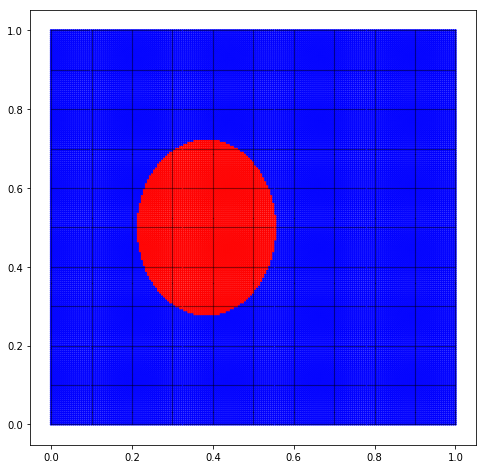

In [7]:
# The true classes are used to select the color
plt.scatter(xv, yv, c=true_classes, cmap="bwr", marker='.', s=10)
a_x, a_y = gridlines(0, 1, 0, 1)
grid=np.array([a_x, a_y])
plt.scatter(a_x, a_y, marker='.', s=.1, c='k')

It's easy to imagine that you can separate red points from blue points in three dimensions. Just imagine you're looking at a piece of cloth, lying on the ground. Grab it in the middle of the red ellipse and lift it a bit, thereby *adding* a dimension to the problem. All red points will be higher up in the air then the blue ones. Here you go - an appropriately positioned horizontal plane will cut (separate) the cloth right a the border between red and blue.

## The Training Data

In [8]:
N = 1000

In [9]:
def createSamples(N, xl, xr, yu, yo, ground_truth):
    """
        ground_truth is a function that calculates the "true" label, given coordinates x and y
        Produce N samples in the rectangle [xl, xr, yu, yo] with the given ground_truth
    """
    np.random.seed(1234)
    x = np.random.uniform(xl,xr,N)
    y = np.random.uniform(yu,yo,N)
    c = ground_truth(x, y) * 1.0
    return x, y, c

In [10]:
sx, sy, sc = createSamples(N, 0, 1, 0, 1, ground_truth)

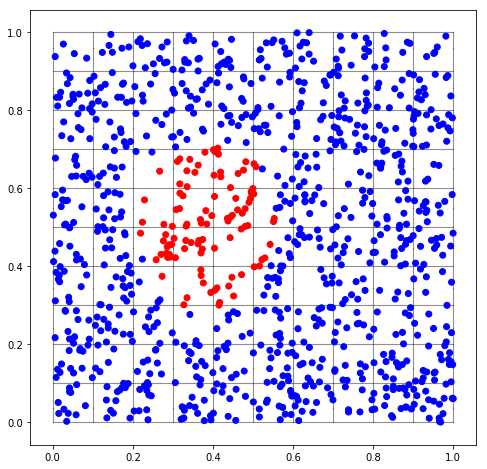

In [11]:
a_x, a_y = gridlines(0, 1, 0, 1)
plt.scatter(a_x, a_y, marker='.', s=.1, c='k')
plt.scatter(sx, sy, c=sc, cmap="bwr", marker='o')

### The Neural Network
Our simple neural network will be defined as

$ f(x) = W_3 \cdot \sigma(W_2 \cdot \sigma(W_1 \cdot x + b_1 ) + b_2) + b_3$

Note, that we omit the final non-linearity at this point. That's for mere technical reasons and doesn't change the story.

Below you see the neural network in code, featuring some illustrative initial values.

You see: We have 2 input nodes, 3 nodes in each of the hidden layers and again 2 nodes in the output layer

In [12]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

W1 = np.array([[1.6, 4], [1.6, -1.2], [-3.6, 1.6]])                  # 3x2 weight Matrix towards the first hidden layer
b1 = np.array([[-1, 1, 6]]).T                                        # bias of the first hidden layer
W2 = np.array([[1, 2, -3], [.5, .2, -3], [2, 1, -.2]])    # 3x3 weight Matrix towards the second hidden layer
b2 = np.array([[.2, .1, -.4]]).T                                     # bias of the 2nd hidden layer
W3 = np.array([[.5, 2, -.03], [.2, 1, -.2]])                     # 2x3 weight Matrix towards the output layer
b3 = np.array([[.2, .3]]).T                                          # bias of the output layer

def fwd(x):
    y = sigmoid(np.matmul(W1, x) + b1)
    y = sigmoid(np.matmul(W2, y) + b2)
    return np.matmul(W3, y) + b3

.

We need coordinate pairs as input to the neural network

In [13]:
grid=np.array([a_x, a_y])
samples=np.array([sx, sy])

.

The ranges are basically what the network function makes out of the input samples and grid

In [14]:
# Apply the network function
grid_range = fwd(grid)
samples_range = fwd(samples)

# A sneek peek to see what we can expect from the outcome
samples.shape, samples[0][0], samples[1][0]

((2, 1000), 0.1915194503788923, 0.40110640866052494)

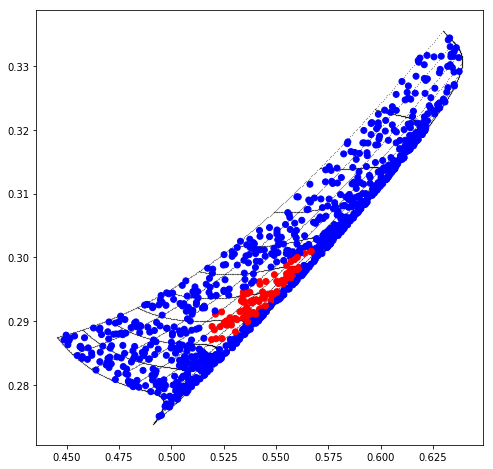

In [15]:
plt.scatter(grid_range[0], grid_range[1], marker='.', s=.1, c='k')
plt.scatter(samples_range[0], samples_range[1], marker='o', c=sc, cmap='bwr')

We can see that the network maps the original space into a particular range. Please observe how the sigmoid non-linearities are able to *bend* the plane

### Tensorflow
To actually train a network we create the equivalent of the above in Tensorflow

In [16]:
# Very helpful for interactive exploration!
sess = tf.InteractiveSession()

#### Using tf.data.Datasets

tf.data.Datasets and their iterators have the nice property that they produce the next batch automatically when referenced.

We create a dataset of positions and classes, so that they will always be iterated together.

In [17]:
training_data = (tf.transpose(samples), tf.transpose(sc))
training_data[0].shape, training_data[1].shape

ds_training = tf.data.Dataset.from_tensor_slices(training_data)
tensor_training = ds_training.batch(N).repeat().make_one_shot_iterator().get_next()

# Let's have a peek into the data to assure ourselves we got it all right
_positions = sess.run(tensor_training)
tensor_training, _positions[0].shape,_positions[1].shape

((<tf.Tensor 'IteratorGetNext:0' shape=(?, 2) dtype=float64>,
  <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=float64>),
 (1000, 2),
 (1000,))

.

Now we also create a dataset from the grid, so we can observe it's topological deformation 

In [18]:
grid_data = tf.data.Dataset.from_tensor_slices(grid.T)
grid_data = grid_data.batch(8822).repeat().make_one_shot_iterator().get_next()
grid_data.shape

TensorShape([Dimension(None), Dimension(2)])

.

This is the *Tensorflow tf.layers* version of the above neural network

In [19]:
#
# NOTE: You need to initialize with the transpose of the weight matrix, otherwise TF mixes up columns and rows
#       Of course that's not a problem, since typically, all numbers are randomly initialized, anyway.
# (can you imagine the frustration until I found out?)
#
W1_i=tf.constant_initializer(W1.T)
b1_i=tf.constant_initializer(b1)
W2_i=tf.constant_initializer(W2.T)
b2_i=tf.constant_initializer(b2)
W3_i=tf.constant_initializer(W3.T)
b3_i=tf.constant_initializer(b3)

def feed_forward(x):
    _dense1=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W1_i, bias_initializer=b1_i)
    _dense2=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W2_i, bias_initializer=b2_i)
    _logits=tf.layers.Dense(2, kernel_initializer=W3_i, bias_initializer=b3_i)    

    y = _dense1(x)
    y = _dense2(y)
    y = _logits(y)
    return y

.

Take the training samples and the grid data in a single go

In [20]:
all_input = tf.concat([tensor_training[0], grid_data], axis = 0)

In [21]:
# pass the data through the network
all_mapped = feed_forward(all_input)

### Running The Network Graph
All steps above have just created the graph, and not actually computed anything

In [22]:
init = tf.global_variables_initializer()
sess.run(init)

In [23]:
_all = sess.run(all_mapped)
_data = _all[:N]
_grid = _all[N:]

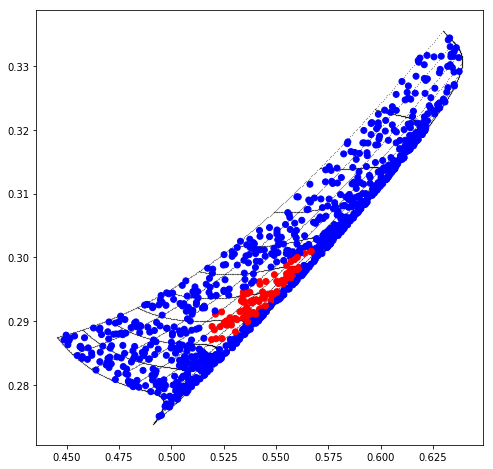

In [24]:
plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
plt.scatter(_data.T[0], _data.T[1], marker='o', c=sc, cmap='bwr')

No surprise. Reproducing the former result was what we set out to achieve. This time, it was Tensorflow compute the mapping - thus we can use its powerful API for the training.
### Set up the Training

In [216]:
sess = tf.InteractiveSession()

In [217]:
all_input = tf.concat([tensor_training[0], grid_data], axis = 0)

In [218]:
true_classes = tf.cast(tensor_training[1], dtype=tf.int64)
input = tensor_training[0]

In [219]:
all_output = feed_forward(all_input)
all_probs = tf.nn.softmax(all_output)
logits = all_output[:N]
probs = tf.nn.softmax(logits)
labels=tf.one_hot(true_classes, depth=2)
objective = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

In [220]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)

In [221]:
train = optimizer.minimize(objective)

In [222]:
preds = tf.argmax(probs[:N],axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, true_classes), dtype=tf.float64))

In [223]:
init = tf.global_variables_initializer()
sess.run(init)

### Training is Hard
You'll need to run the following cell 40 times. You'll see it getting stuck and fighting its way to success after about 35 steps. Then it finally improves step by step until it actually fits the entire training set

In [224]:
losses = []
accies = []
n_batch = 50

In [225]:
def draw_manifold(output):
    _data = output[:N]
    _grid = output[N:]
    plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
    plt.scatter(_data.T[0], _data.T[1], marker='.', c=sc, cmap='bwr')

In [226]:
def single_batch(n_batch):
    for _ in range(n_batch):
        _, _all_output, _objective, _accuracy = sess.run([train, all_output, objective, accuracy])

    print ("Loss: %s - Accuracy: %s" % (_objective, _accuracy))
    losses.append(_objective)
    accies.append(_accuracy)
    return _all_output


Loss: 0.024194904431789878 - Accuracy: 0.993


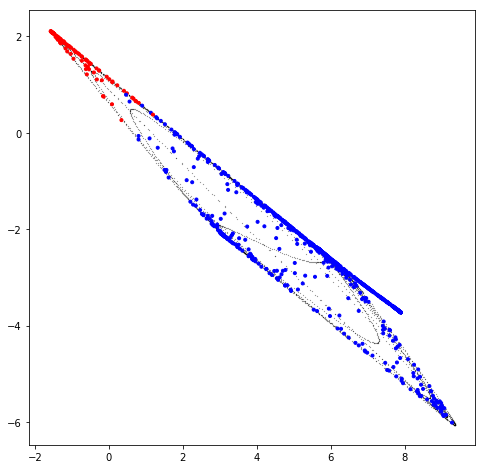

In [247]:
# Do a couple of training steps, don't loose your patience. It takes quite some time for the training to kick in
for _ in range (1): # Go by 10 single steps, then 25, then single steps again 
    _all_output = single_batch(n_batch)

    #for _ in range(n_batch):
    #    _, _all_output, _objective, _accuracy = sess.run([train, all_output, objective, accuracy])
    #print ("Loss: %s - Accuracy: %s" % (_objective, _accuracy))
    #losses.append(_objective)
    #accies.append(_accuracy)

# plot the resulting topology
#draw_manifold(_all_output)
_data = _all_output[:N]
_grid = _all_output[N:]
plt.scatter(_grid.T[0], _grid.T[1], marker='.', s=.1, c='k')
plt.scatter(_data.T[0], _data.T[1], marker='.', c=sc, cmap='bwr')

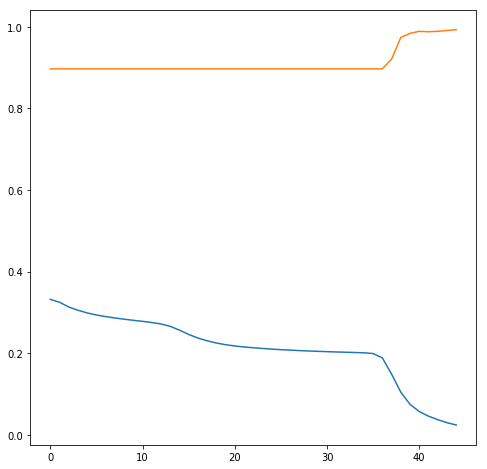

In [248]:
plt.plot(losses)
plt.plot(accies)